# [LAB-13] 4. ARIMA - 모형 학습 및 예측

- 시계열데이터 분석 전용 통계모형
- `AR(p) x I(차분, d) x MA(q)`를 결합한 모형으로, 일반적인 시계열 분석 때 쓰인다.
- ARIMA 분석을 위한 절차:
  - 1. `시간축을 인덱스로` 설정하기
  - 2. `계절성(s)` 여부 파악하기 - by 시각화 in EDA `시계열분해`
  - 3. `차분(d)`값 추정하기 - in 데이터 전처리 when `ADF test` for 정상성 여부 파악
  - 4. `추정 파라미터` 찾기 - `(p, q)` by `ACF, PACF` 파라미터 탐색 and 플로팅 w/ `원본데이터`
  - 5. `모형 학습` 및 미래 `예측 시각화`하기 - by `SARIMAX`와 찾은 추정값(p, d, q) w/ `원본데이터`

## #01. 준비작업

### 1. 라이브러리 가져오기

In [1]:
# 0. 기본 참조:
from hossam import load_data
from pandas import melt, DataFrame
from matplotlib import pyplot as plt
from matplotlib import font_manager as fm
# 그래프 축이 날짜 형식일 때 출력날짜 포멧 지정용
from matplotlib import dates
import seaborn as sb

# 1. 탐색적 데이터 분석: 시계열분해 패키지:
from statsmodels.tsa.seasonal import seasonal_decompose

# 2. 데이터 전처리: ADF Test - 정상성(평균 일정) 확인용:
from statsmodels.tsa.stattools import adfuller
# 2. 데이터 전처리: ACF, PACF 파라미터 탐색용:
from statsmodels.tsa.stattools import acf, pacf
# 2. 데이터 전처리: ACF, PACF 시각화용:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# 3. ARIMA 모델 학습 및 예측용:
from statsmodels.tsa.arima.model import ARIMA

### 2. 시각화 초기화

In [2]:
my_dpi = 200  # 이미지 선명도 (100~300)
font_path = r"\Users\itwill\OneDrive\문서\학원수업\NotoSansKR-Regular.ttf"  # 한글을 지원하는 폰트 파일의 경로
fm.fontManager.addfont(font_path)      # 폰트 글꼴을 시스템에 등록함
font_prop = fm.FontProperties(fname = font_path)    # 폰트 속성을 읽어옴
font_name = font_prop.get_name()    # 읽어온 속성에서 폰트의 이름만 추출

plt.rcParams['font.family'] = font_name # 그래프에 한글폰트 적용
plt.rcParams['font.size'] = 6          # 기본 폰트 크기
plt.rcParams['axes.unicode_minus'] = False  
    # 그래프에 마이너스 깨짐 방지 (한글 환경에선 필수)

### 3. 데이터 가져오기

In [3]:
origin = load_data('air_passengers')

print("\n===== 데이터 크기 확인 =====")
print(f"데이터셋 크기: {origin.shape}")
print(f"열 갯수: {origin.shape[1]}")
print(f"행 갯수: {origin.shape[0]}")

print("\n===== 타입 확인 =====")
print(origin.info())

origin.head()

[data] https://data.hossam.kr/data/lab13_/air_passengers.xlsx
[desc] 어느 항공사의 월간 탑승객 수 (출처: https://www.kaggle.com/datasets/rakannimer/air-passengers)
[!] Cannot read metadata

===== 데이터 크기 확인 =====
데이터셋 크기: (144, 2)
열 갯수: 2
행 갯수: 144

===== 타입 확인 =====
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Month       144 non-null    datetime64[ns]
 1   Passengers  144 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 2.4 KB
None


,Month,Passengers
0,1949-01-01,112
1,1949-02-01,118
2,1949-03-01,132
3,1949-04-01,129
4,1949-05-01,121


### 4. 데이터 전처리

ARIMA 분석을 위한 데이터 전처리는 시간축을 인덱스 설정하는 것만 하면 됨.

In [4]:
df = origin.set_index("Month")
df.head()

,Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


## #02. ARIMA 분석모델 만들기

### 1. 최적 모형을 위한 파라미터 찾기

In [ ]:
p = 2 # 직전 파라미터 탐색 단계에서 찾은 max값(추정치)임
d = 2 # ↑
q = 2 # ↑

results = [] # 결과저장용

# 1. 모델 학습시키기:
for x in range(0, p+1):
    for y in range(0, d+1):
        for z in range(0, q+1):
            try:
                # 1. 비계절성(ARIMA) 모델 객체 생성:
                #model = ARIMA(df['Passengers'], order=(x, y, z))
                # 1. 계절성(SARIMAX) 모델 객체 생성:
                model = ARIMA(
                    df['Passengers'], order=(x, y, z),
                    seasonal_order=(x, y, z, 6)) # ARIMA 모델에 계절성(6개월 단위) 추가
                # 2. 모델 학습:
                fit = model.fit()
                # 3. 각 학습 당 결과값 저장:
                results.append({
                    'p': x,
                    'd': y,
                    'q': z,
                    'AIC': fit.aic,
                    'BIC': fit.bic
                })
            except Exception as e:
                # 4. 학습(수렴) 실패 or 모형 오류는 건너뛰기
                continue

df_results = DataFrame(results)

# 2. 학습들 중 최적값 찾기:

# 방법1 - 기준: AIC+BIC 합산점수의 최솟값
#df_results['AIC_rank'] = df_results['AIC'].rank()
#df_results['BIC_rank'] = df_results['BIC'].rank()

#df_results['rank_sum'] = df_results['AIC_rank'] + df_results['BIC_rank']

#best_model = df_results.sort_values('rank_sum').iloc[0]
#best_model

# 방법2 - 보수적 기준: 최소 BIC값 우선 → BIC값 같을 경우 최소 AIC값 보조
best_model = df_results.sort_values(['BIC', 'AIC']).iloc[0]
best_model

c:\Users\itwill\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\itwill\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\itwill\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\itwill\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\itwill\AppData\Local\Programs\Python\Python

p         1.000000
d         2.000000
q         1.000000
AIC    1072.901835
BIC    1087.239507
Name: 16, dtype: float64

### 2. 도출된 최적값으로 최종모형 생성

In [7]:
best_order = (
    int(best_model['p']),
    int(best_model['d']),
    int(best_model['q'])
)

s_best_order = (
    int(best_model['p']),
    int(best_model['d']),
    int(best_model['q']),
    6
)

final_model = ARIMA(df['Passengers'], order=best_order,
                    seasonal_order = s_best_order)
final_fit = final_model.fit()

print(final_fit.summary())

c:\Users\itwill\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\itwill\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\itwill\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                                    SARIMAX Results                                    
Dep. Variable:                      Passengers   No. Observations:                  144
Model:             ARIMA(1, 2, 1)x(1, 2, 1, 6)   Log Likelihood                -531.451
Date:                            목, 18 12 2025   AIC                           1072.902
Time:                                 15:01:54   BIC                           1087.240
Sample:                             01-01-1949   HQIC                          1078.728
                                  - 12-01-1960                                         
Covariance Type:                           opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2969      0.080     -3.709      0.000      -0.454      -0.140
ma.L1         -0.9996      5.635     -0.177      0.859     

c:\Users\itwill\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


## #03. 분석 결과 해석

### 1. 모형구조 정보


### 2. 모형적합도 지표


### 3. 계수 추정 결과


### 4. 잔차 진단지표 (a.k.a. 모형 타당성)


### 5. 결과보고 함수 만들어놓기

In [21]:
def arima_report(fit, data, threshold=0.05):
    """
    input: SARIMAX Results 객체(fit), 원본데이터(data)
    output:
    - 1. 모형적합도 표(cdf),
    - 2. 계수 테이블(rdf),
    - 3. 모형요약 문장(result_report),
    - 4. 모형판정 문장(model_report),
    - 5. 계수 당 해석문장(variable_reports)
    """

    # ------------------------------------------
    # 1. 모형적합도 표(cdf) 생성
    # ------------------------------------------
    cdf = DataFrame({
        "Log Likelihood": [fit.llf],
        "AIC": [fit.aic],
        "BIC": [fit.bic],
        "HQIC": [fit.hqic],
        "Observation": [fit.nobs]
    })

    # ------------------------------------------
    # 2. 계수 테이블(rdf) 생성
    # ------------------------------------------
    params = fit.params
    bse = fit.bse
    zvals = params / bse
    pvals = fit.pvalues
    conf = fit.conf_int()

    rows = []
    for name in params.index:
        p = pvals[name]
        stars = (
            "***" if p < 0.001 else
            "**" if p < 0.01 else
            "*" if p < 0.05 else
            ""
        )
    
        rows.append({
            "모델": name,
            "계수": params[name],
            "표준오차": bse[name],
            "z": f"{zvals[name]: .3f}{stars}",
            "p-value": p,
            "CI_from": conf.loc[name, 0],
            "CI_to": conf.loc[name, 1]      
        })
    
    rdf = DataFrame(rows)

    # ------------------------------------------
    # 3. 모형요약 문장(result_report) 구성
    # ------------------------------------------
    result_report = (
        f"Log Likelihood = {fit.llf: .3f},"
        f"AIC = {fit.aic: .3f},"
        f"BIC = {fit.bic: .3f}."
    )

    # ------------------------------------------
    # 4. 모형판정 문장(model_report) 구성
    # ------------------------------------------
    lb = fit.test_serial_correlation(method="ljungbox")
    # statsmodels 버전마다 pvalue 값의 인덱스가 상이함
    lb_pvalue = lb[0][1][-1]
    
    model_report = (
        f"ARIMA{fit.model.order}×{fit.model.seasonal_order} 모형을 적합한 결과,"
        f"AIC = {fit.aic: .3f}, BIC = {fit.bic: .3f}가 최적값으로 나타났으며 "
    )

    if lb_pvalue >= threshold:
        model_report += (
            "잔차들 사이에서 특별한 시간적 패턴은 관찰되지 않음을 통계적으로 확인하였다."
            "(잔차의 자기상관은 Ljung-Box 검정에서 유의미하지 않았다)"
        )
    else:
        model_report += (
            "잔차들 사이에서 시간적 패턴이 남아있는 것으로 나타났으며, "
            "모형이 충분히 설명하지 못했을 가능성이 있다."
            "(잔차의 자기상관이 Ljung-Box 검정에서 통계적으로 유의미 하였다)"
        )

    # ------------------------------------------
    # 5. 계수 당 해석문장(variable_reports) 구성
    # ------------------------------------------
    variable_reports = []

    for _, row in rdf.iterrows():
        variable_reports.append(
            f"{row['모델']} 모델의 계수(과거 값의 영향력)는 {row['계수']:.3f}로 "
            f"통계적으로 {'유의하다' if row['p-value'] < threshold else '유의하지 않다'} "
            f"(p {'<' if row['p-value'] < threshold else '>'} {threshold})."
        )

    # ------------------------------------------
    # 결과 반환하기
    # ------------------------------------------
    return cdf, rdf, result_report, model_report, variable_reports

In [22]:
cdf, rdf, result_report, model_report, variable_reports = arima_report(final_fit, df)
display("1. 모형적합도:")
display(cdf)
display("2. 계수 테이블:")
display(rdf)
print("3. 모형요약:")
display(result_report)
print("4. 모형판정 결과:")
display(model_report)
print("5. 계수 별 해석:")
display(variable_reports)

'1. 모형적합도:'

,Log Likelihood,AIC,BIC,HQIC,Observation
0,-531.450917,1072.901835,1087.239507,1078.72771,144


'2. 계수 테이블:'

,모델,계수,표준오차,z,p-value,CI_from,CI_to
0,ar.L1,-0.296878,0.080038,-3.709***,0.000208,-0.453749,-0.140007
1,ma.L1,-0.999587,5.635402,-0.177,0.859213,-12.044772,10.045598
2,ar.S.L6,-0.984122,0.011507,-85.526***,0.000000,-1.006675,-0.961569
3,ma.S.L6,-0.996244,1.991822,-0.500,0.616957,-4.900144,2.907656
4,sigma2,134.605180,795.200757,0.169,0.865583,-1423.959664,1693.170023


3. 모형요약:


'Log Likelihood = -531.451,AIC =  1072.902,BIC =  1087.240.'

4. 모형판정 결과:


'ARIMA(1, 2, 1)×(1, 2, 1, 6) 모형을 적합한 결과,AIC =  1072.902, BIC =  1087.240가 최적값으로 나타났으며 잔차들 사이에서 특별한 시간적 패턴은 관찰되지 않음을 통계적으로 확인하였다.(잔차의 자기상관은 Ljung-Box 검정에서 유의미하지 않았다)'

5. 계수 별 해석:


['ar.L1 모델의 계수(과거 값의 영향력)는 -0.297로 통계적으로 유의하다 (p < 0.05).',
 'ma.L1 모델의 계수(과거 값의 영향력)는 -1.000로 통계적으로 유의하지 않다 (p > 0.05).',
 'ar.S.L6 모델의 계수(과거 값의 영향력)는 -0.984로 통계적으로 유의하다 (p < 0.05).',
 'ma.S.L6 모델의 계수(과거 값의 영향력)는 -0.996로 통계적으로 유의하지 않다 (p > 0.05).',
 'sigma2 모델의 계수(과거 값의 영향력)는 134.605로 통계적으로 유의하지 않다 (p > 0.05).']

## #04. 최적화 시킨 ARIMA 모델 활용하기 - 승객 수 예측

### 1. 분석 결과에 의한 예측값

In [18]:
df2 = df.copy()
df2['pred'] = fit.fittedvalues # 학습결과로 기존 값의 예측값 생성
df2.head()

,Passengers,pred
Month,,
1949-01-01,112,0.000000
1949-02-01,118,194.445102
1949-03-01,132,127.029841
1949-04-01,129,145.056588
1949-05-01,121,126.210041


### 2. 이후 1년간의 추가 예측값 생성하기: `.forecast(갯수)`

In [19]:
fc = fit.forecast(12)
fc

1961-01-01    448.407470
1961-02-01    419.224376
1961-03-01    444.209056
1961-04-01    487.239580
1961-05-01    496.840956
1961-06-01    563.045412
1961-07-01    654.262513
1961-08-01    635.664972
1961-09-01    533.310876
1961-10-01    485.670084
1961-11-01    411.744318
1961-12-01    456.622878
Freq: MS, Name: predicted_mean, dtype: float64

### 3. 관측치와 예측치 비교 후 추가 예측치 덧붙이기

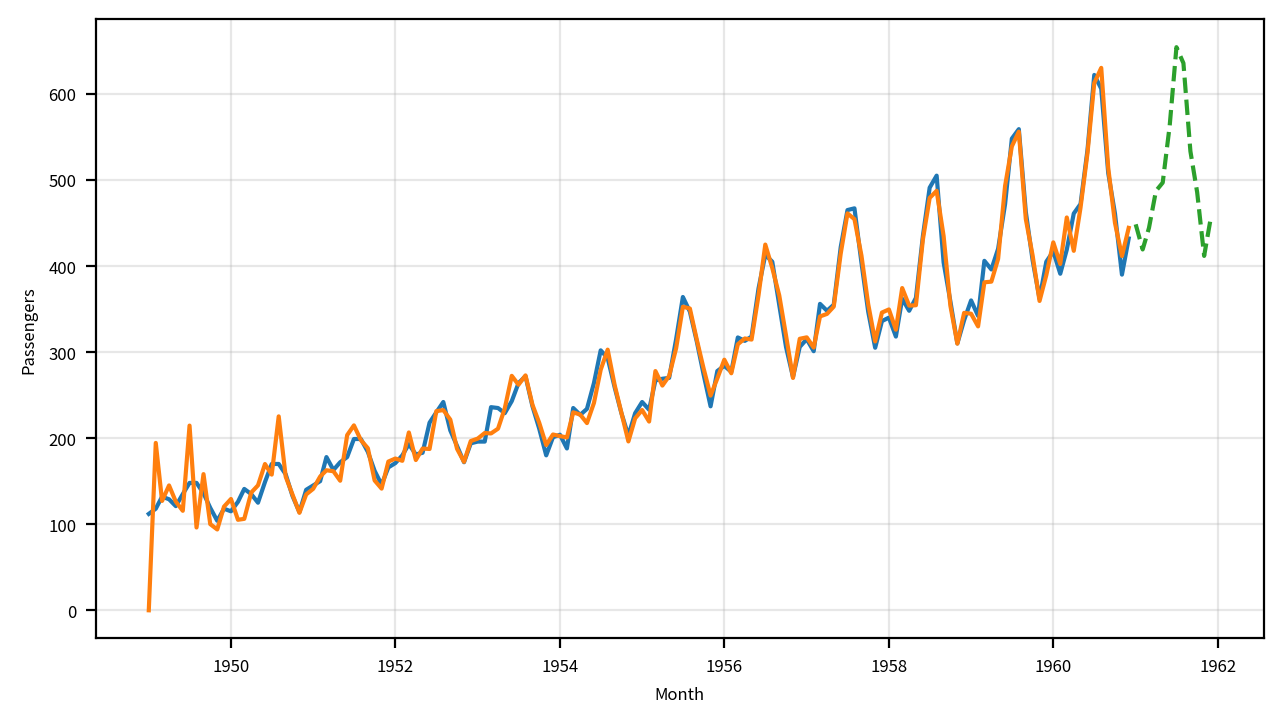

In [20]:
# 1) 그래프 초기화
width_px = 1280
height_px = 720
rows = 1
cols = 1
figsize = (width_px / my_dpi, height_px / my_dpi)
fig, ax = plt.subplots(rows, cols, figsize = figsize, dpi = my_dpi)

# 2) lineplot 그래프 그리기 (seaborn 사용)
# 관측치:
sb.lineplot(data=df2, x=df2.index, y="Passengers")
# 예측치:
sb.lineplot(data=df2, x=df2.index, y='pred')
# 이후 예상:
sb.lineplot( x=fc.index, y=fc.values, linestyle='--')

# 3) 꾸미기
ax.grid(True, alpha=0.3)    # 배경격자

# 4) 출력
plt.tight_layout()
plt.show()
plt.close()